In [1]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("AQI_final.csv")

# Handle missing values by replacing them with the median
if data.isnull().sum().any():
    data.fillna(data.median(), inplace=True)

# Drop irrelevant columns
data_processed = data.drop(columns=["City", "Date", "AQI_Bucket"])

In [5]:
# Split into features and target
X = data_processed.drop(columns=["AQI"])  # All columns except AQI
y = data_processed["AQI"]  # AQI is the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Optional: Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

Training Features: (5560, 12), Testing Features: (1391, 12)


In [17]:
# -------------------------------
# Option 2: GridSearchCV
# -------------------------------
# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Perform GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Retrieve best parameters and best RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("\nGridSearchCV results:")
print(f"Best parameters: {best_params}")
print(f"Best RMSE from GridSearchCV: {best_rmse:.2f}")


y_mean = np.mean(y_train)

# Create a baseline prediction array where every prediction is the mean
y_baseline_pred = np.full_like(y_test, y_mean, dtype=np.float64)

# Calculate baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_baseline_pred))
print("\nBaseline results:")
print(f"Baseline RMSE: {baseline_rmse:.2f}")


GridSearchCV results:
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE from GridSearchCV: 23.13

Baseline results:
Baseline RMSE: 89.75


In [19]:
final_model = xgb.XGBRegressor(**(best_params if 'best_params' in locals() else {}), random_state=42)
final_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_test = final_model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = mean_absolute_percentage_error(y_test, y_pred_test)

print("\nFinal model evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")


Final model evaluation:
R²: 0.9436
MAE: 14.33
RMSE: 21.31
MAPE: 0.12


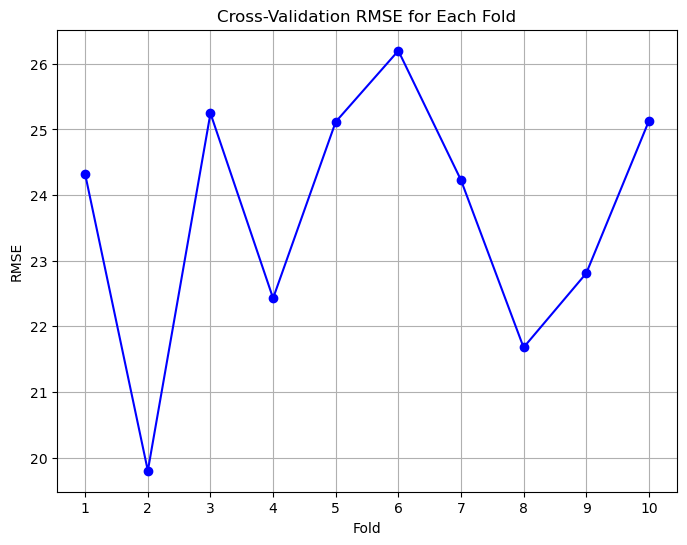

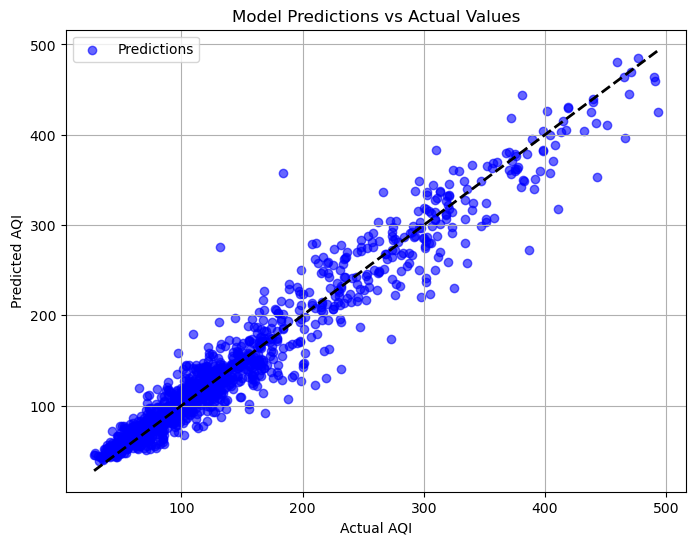

<Figure size 800x600 with 0 Axes>

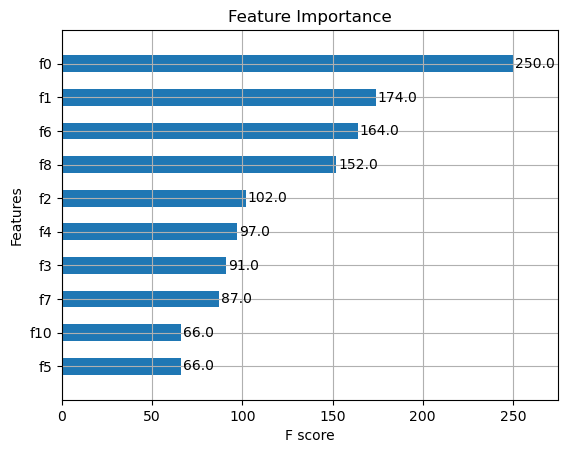

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cv_rmse) + 1), cv_rmse, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.xticks(np.arange(1, len(cv_rmse) + 1))
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10, title="Feature Importance", height=0.5)
plt.show()
